# Step 1 - Business Understanding

## Problem Definition

### Primary Problem Statement
This project aims to **predict player performance metrics in the NBA**, specifically focusing on predicting a player's points per game (PPG) in upcoming seasons based on historical career statistics and performance trends. This represents a **regression problem** with a continuous numeric response variable.

**Response Variable:** Points Per Game (PPG) - Continuous numerical variable

### Business Context and Industry Importance

#### Relevance to NBA Teams and Franchises
Player performance prediction is critically important for NBA organisations for several key reasons:

1. **Contract Negotiations and Salary Cap Management**: Teams operate under strict salary cap constraints. Accurately predicting a player's future performance helps management make informed decisions about contract offers, extensions, and trade valuations, potentially saving millions of pounds in overpayments or identifying undervalued talent.

2. **Draft Strategy and Talent Acquisition**: Understanding performance trajectories helps teams evaluate draft prospects and potential acquisitions, enabling more strategic roster construction and long-term planning.

3. **Game Strategy and Coaching Decisions**: Predicting player output assists coaching staff in lineup optimisation, playing time allocation, and tactical planning throughout the season.

4. **Injury Prevention and Load Management**: Identifying performance decline patterns may indicate injury risks or fatigue, allowing teams to implement preventive measures and optimise player rest schedules.

#### Broader Industry Applications

1. **Sports Analytics Industry**: The methodologies developed can be applied across other professional sports leagues (Premier League, NFL, MLB) for similar performance prediction challenges.

2. **Sports Betting and Fantasy Sports**: Accurate performance predictions drive billions in revenue for betting companies and daily fantasy sports platforms, where player projections directly impact odds-setting and user engagement.

3. **Sports Media and Broadcasting**: Media organisations use performance predictions for content creation, pre-match analysis, and viewer engagement, enhancing the fan experience.

4. **Player Development and Training**: Youth academies and development programmes can use predictive insights to optimise training regimens and identify areas requiring additional focus.

### Associated Problems and Analysis Requirements

#### Predictor Variable Profiling
We need to examine and understand the characteristics of various predictor variables, including:
- Games played (GP)
- Minutes played (MIN)
- Field goal percentage (FG%)
- Three-point percentage (3P%)
- Free throw percentage (FT%)
- Rebounds (REB)
- Assists (AST)
- Steals (STL)
- Blocks (BLK)
- Turnovers (TOV)
- Player age and experience level
- Season and team context

#### Relationship Analysis Requirements
1. **Predictor-to-Predictor Relationships**: 
   - Identify multicollinearity amongst predictor variables
   - Understand how variables like minutes played correlate with other statistics
   - Examine temporal dependencies (how previous season performance affects current season)

2. **Predictor-to-Response Relationships**:
   - Determine which variables have the strongest predictive power for PPG
   - Identify non-linear relationships that may require transformation
   - Analyse interaction effects between variables

### Research Questions

1. Which historical performance metrics are the strongest predictors of future points per game?
2. How does player age and career stage impact performance trajectory?
3. Are there identifiable patterns that distinguish players who improve versus those who decline?
4. What is the optimal combination of variables for accurate PPG prediction?
5. How do team changes and contextual factors influence individual player performance?

### Project Objectives

1. Develop a robust predictive model for player PPG with acceptable accuracy (target: R² > 0.75)
2. Identify key performance indicators that drive scoring output
3. Create actionable insights for team management and player evaluation
4. Validate model performance across different player archetypes and positions
5. Provide a scalable framework applicable to other performance metrics

# Step 2 - Data Mining

### Retrieve player names

In [5]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats
import pandas as pd
import time
import matplotlib.pyplot as plt

# get all players in the NBA
nba_players = players.get_players()

# convert to pandas dataframe
players_df = pd.DataFrame(nba_players)
# filter only active & recently retired players
players_df = players_df[players_df["is_active"] == True]

players_df.head()

,id,full_name,first_name,last_name,is_active
10,1630173,Precious Achiuwa,Precious,Achiuwa,True
22,203500,Steven Adams,Steven,Adams,True
24,1628389,Bam Adebayo,Bam,Adebayo,True
29,1630534,Ochai Agbaji,Ochai,Agbaji,True
41,1630583,Santi Aldama,Santi,Aldama,True


### Use player ID's to get stats and save to csv

In [6]:
all_player_stats = pd.DataFrame()

# loop through player list and pull stats for each
for i, row in players_df.iterrows():
    pid = row["id"]
    name = row["full_name"]
    
    try:
        career = playercareerstats.PlayerCareerStats(player_id=pid)
        df = career.get_data_frames()[0]
        
        # add the id and name
        df["PLAYER_ID"] = pid
        df["PLAYER_NAME"] = name
        
        # append to final DataFrame
        all_player_stats = pd.concat([all_player_stats, df], ignore_index=True)

        # pause to avoid rate limit
        time.sleep(0.6)
    
    except Exception as e:
        print(f"Error retrieving data for {name}: {e}")
        continue


# reorder columns
cols = ["PLAYER_ID", "PLAYER_NAME"] + [col for col in all_player_stats.columns if col not in ["PLAYER_ID", "PLAYER_NAME"]]
all_player_stats = all_player_stats[cols]
    
# save to csv
all_player_stats.to_csv("playerStats.csv", index=False)

/tmp/ipykernel_48183/3153091106.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_player_stats = pd.concat([all_player_stats, df], ignore_index=True)


Error retrieving data for Cui Cui: 'resultSet'


# Step 3 - Data Cleaning

In [30]:
data = pd.read_csv("playerStats.csv")

## Data Types & Describe

### Data Types

| No. | Variable            | Type    | Role                                                                |
| --- | ------------------- | ------- | ------------------------------------------------------------------- |
| 1   | `PLAYER_ID`         | int64   | Ignore (identifier)                                                 |
| 2   | `PLAYER_NAME`       | object  | Ignore (identifier)                                                 |
| 3   | `SEASON_ID`         | object  | Optional categorical – Context (can use if modeling across seasons) |
| 4   | `LEAGUE_ID`         | object  | Ignore (constant)                                                   |
| 5   | `TEAM_ID`           | int64   | Ignore (redundant identifier)                                       |
| 6   | `TEAM_ABBREVIATION` | object  | Categorical – Optional explanatory (if one-hot encoded)             |
| 7   | `PLAYER_AGE`        | float64 | Numerical – Explanatory (used to predict)                           |
| 8   | `GP`                | int64   | Numerical – Explanatory (used to predict)                           |
| 9   | `GS`                | int64   | Ignore (highly correlated with `MIN`)                               |
| 10  | `MIN`               | int64   | Numerical – Explanatory (used to predict)                           |
| 11  | `FGM`               | int64   | Ignore (redundant with `FGA` × `FG_PCT`)                            |
| 12  | `FGA`               | int64   | Numerical – Explanatory (used to predict)                           |
| 13  | `FG_PCT`            | float64 | Numerical – Explanatory (used to predict)                           |
| 14  | `FG3M`              | int64   | Ignore (redundant with `FG3A` × `FG3_PCT`)                          |
| 15  | `FG3A`              | int64   | Numerical – Explanatory (used to predict)                           |
| 16  | `FG3_PCT`           | float64 | Numerical – Explanatory (used to predict)                           |
| 17  | `FTM`               | int64   | Ignore (redundant with `FTA` × `FT_PCT`)                            |
| 18  | `FTA`               | int64   | Numerical – Explanatory (used to predict)                           |
| 19  | `FT_PCT`            | float64 | Numerical – Explanatory (used to predict)                           |
| 20  | `OREB`              | int64   | Ignore (covered by total rebounds `REB`)                            |
| 21  | `DREB`              | int64   | Ignore (covered by total rebounds `REB`)                            |
| 22  | `REB`               | int64   | Numerical – Explanatory (used to predict)                           |
| 23  | `AST`               | int64   | Numerical – Explanatory (used to predict)                           |
| 24  | `STL`               | int64   | Numerical – Explanatory (used to predict)                           |
| 25  | `BLK`               | int64   | Numerical – Explanatory (used to predict)                           |
| 26  | `TOV`               | int64   | Numerical – Explanatory (used to predict)                           |
| 27  | `PF`                | int64   | Numerical – Explanatory (used to predict)                           |
| 28  | `PTS`               | int64   | Numerical – **Response (target variable to predict)**               |


In [32]:
print("Data Info")
print(data.info())
print(data.head())

Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4037 entries, 0 to 4036
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PLAYER_ID          4037 non-null   int64  
 1   PLAYER_NAME        4037 non-null   object 
 2   SEASON_ID          4037 non-null   object 
 3   LEAGUE_ID          4037 non-null   int64  
 4   TEAM_ID            4037 non-null   int64  
 5   TEAM_ABBREVIATION  4037 non-null   object 
 6   PLAYER_AGE         4037 non-null   float64
 7   GP                 4037 non-null   int64  
 8   GS                 4037 non-null   int64  
 9   MIN                4037 non-null   int64  
 10  FGM                4037 non-null   int64  
 11  FGA                4037 non-null   int64  
 12  FG_PCT             4037 non-null   float64
 13  FG3M               4037 non-null   int64  
 14  FG3A               4037 non-null   int64  
 15  FG3_PCT            4037 non-null   float64
 16  FTM           

### Describe Data

In [33]:
summaryNumerical = data.describe()
print(summaryNumerical)

          PLAYER_ID  LEAGUE_ID       TEAM_ID   PLAYER_AGE           GP  \
count  4.037000e+03     4037.0  4.037000e+03  4037.000000  4037.000000   
mean   1.164591e+06        0.0  1.488929e+09    25.651722    46.292792   
std    6.715004e+05        0.0  4.257032e+08     3.971227    25.745245   
min    2.544000e+03        0.0  0.000000e+00    19.000000     1.000000   
25%    2.038970e+05        0.0  1.610613e+09    23.000000    22.000000   
50%    1.628418e+06        0.0  1.610613e+09    25.000000    51.000000   
75%    1.630217e+06        0.0  1.610613e+09    28.000000    69.000000   
max    1.642530e+06        0.0  1.610613e+09    40.000000    84.000000   

                GS          MIN          FGM          FGA       FG_PCT  ...  \
count  4037.000000  4037.000000  4037.000000  4037.000000  4037.000000  ...   
mean     26.059698  1159.958137   205.713401   437.732227     0.464023  ...   
std      27.632789   853.919226   184.070088   387.148089     0.101263  ...   
min       0.00000

## Data Cleaning

### Manipulate Columns

In [34]:
# drop columns that are do not help with predictions
data.drop(["PLAYER_ID", "PLAYER_NAME", "TEAM_ABBREVIATION", "SEASON_ID", "LEAGUE_ID"], axis=1, inplace=True)

# Drop values that can be dervived from others or are highly correlated
data.drop(["FGM", "FG3M", "FTM", "GS", "OREB", "DREB","FGA", "FTA", "TOV", ], axis=1, inplace=True)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4037 entries, 0 to 4036
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TEAM_ID     4037 non-null   int64  
 1   PLAYER_AGE  4037 non-null   float64
 2   GP          4037 non-null   int64  
 3   MIN         4037 non-null   int64  
 4   FG_PCT      4037 non-null   float64
 5   FG3A        4037 non-null   int64  
 6   FG3_PCT     4037 non-null   float64
 7   FT_PCT      4037 non-null   float64
 8   REB         4037 non-null   int64  
 9   AST         4037 non-null   int64  
 10  STL         4037 non-null   int64  
 11  BLK         4037 non-null   int64  
 12  PF          4037 non-null   int64  
 13  PTS         4037 non-null   int64  
dtypes: float64(4), int64(10)
memory usage: 441.7 KB
None


### Deal with Missing Values

In [35]:
# checking the missing values in the dataset
numberMissing = data.isnull().sum()
print(f"Number of missing values:\n{numberMissing}")


Number of missing values:
TEAM_ID       0
PLAYER_AGE    0
GP            0
MIN           0
FG_PCT        0
FG3A          0
FG3_PCT       0
FT_PCT        0
REB           0
AST           0
STL           0
BLK           0
PF            0
PTS           0
dtype: int64


## Deal with Outliers - Numerical Variables

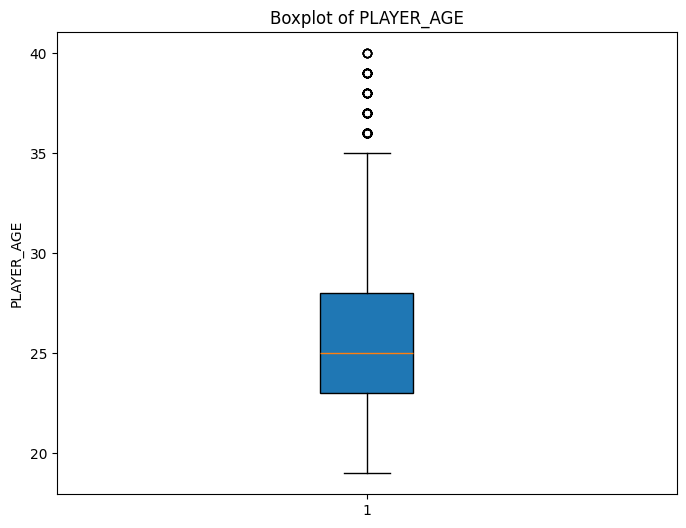


Summary statistics for PLAYER_AGE:
count    4037.000000
mean       25.651722
std         3.971227
min        19.000000
25%        23.000000
50%        25.000000
75%        28.000000
max        40.000000
Name: PLAYER_AGE, dtype: float64
------------------------------------------------------------


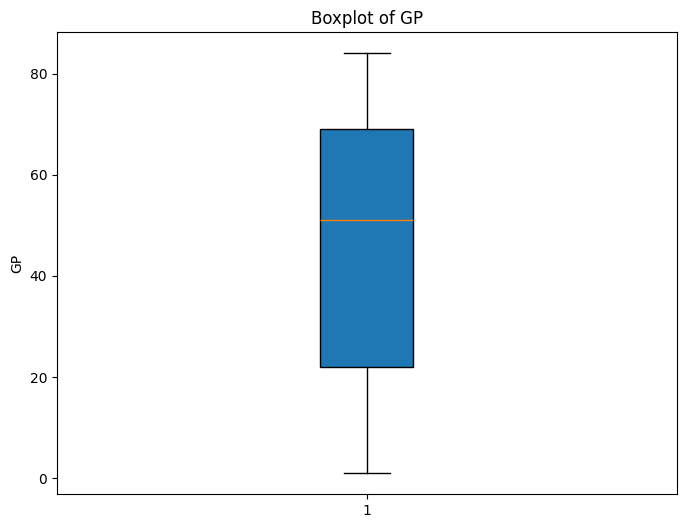


Summary statistics for GP:
count    4037.000000
mean       46.292792
std        25.745245
min         1.000000
25%        22.000000
50%        51.000000
75%        69.000000
max        84.000000
Name: GP, dtype: float64
------------------------------------------------------------


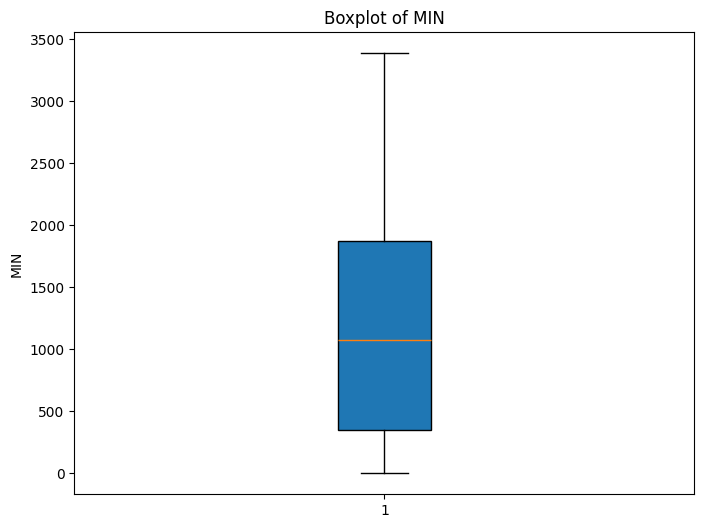


Summary statistics for MIN:
count    4037.000000
mean     1159.958137
std       853.919226
min         1.000000
25%       349.000000
50%      1079.000000
75%      1878.000000
max      3388.000000
Name: MIN, dtype: float64
------------------------------------------------------------


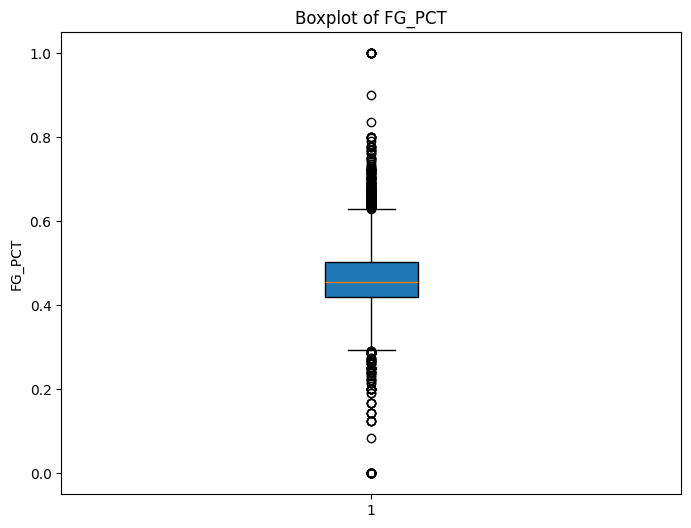


Summary statistics for FG_PCT:
count    4037.000000
mean        0.464023
std         0.101263
min         0.000000
25%         0.419000
50%         0.456000
75%         0.503000
max         1.000000
Name: FG_PCT, dtype: float64
------------------------------------------------------------


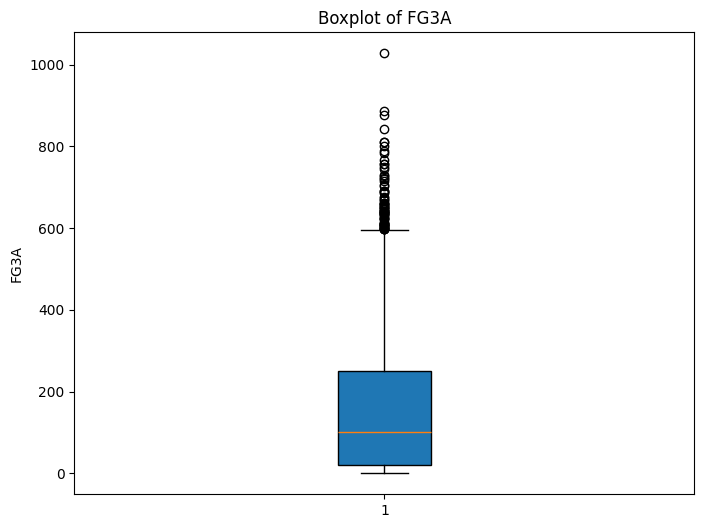


Summary statistics for FG3A:
count    4037.000000
mean      155.502601
std       160.472048
min         0.000000
25%        21.000000
50%       101.000000
75%       251.000000
max      1028.000000
Name: FG3A, dtype: float64
------------------------------------------------------------


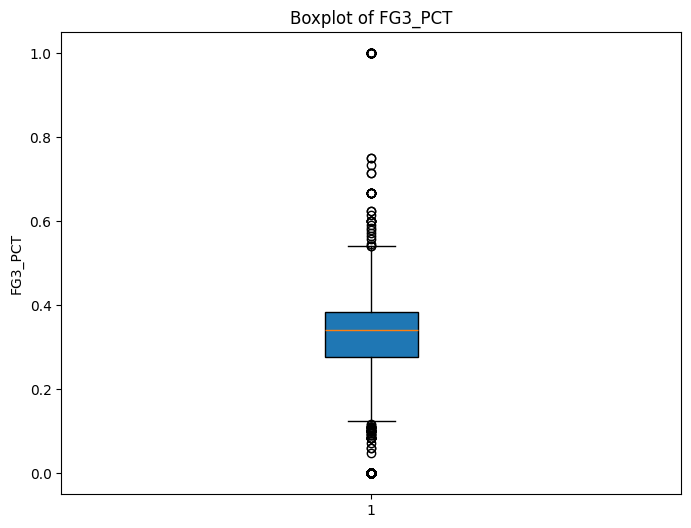


Summary statistics for FG3_PCT:
count    4037.000000
mean        0.308215
std         0.143601
min         0.000000
25%         0.278000
50%         0.340000
75%         0.383000
max         1.000000
Name: FG3_PCT, dtype: float64
------------------------------------------------------------


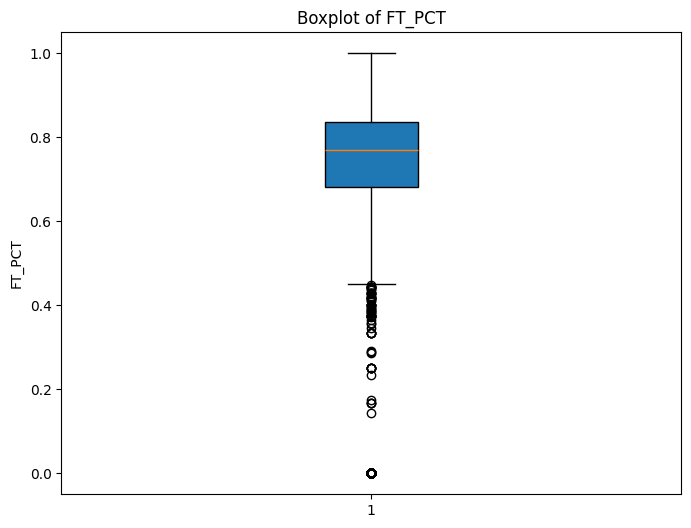


Summary statistics for FT_PCT:
count    4037.000000
mean        0.729175
std         0.191254
min         0.000000
25%         0.682000
50%         0.770000
75%         0.837000
max         1.000000
Name: FT_PCT, dtype: float64
------------------------------------------------------------


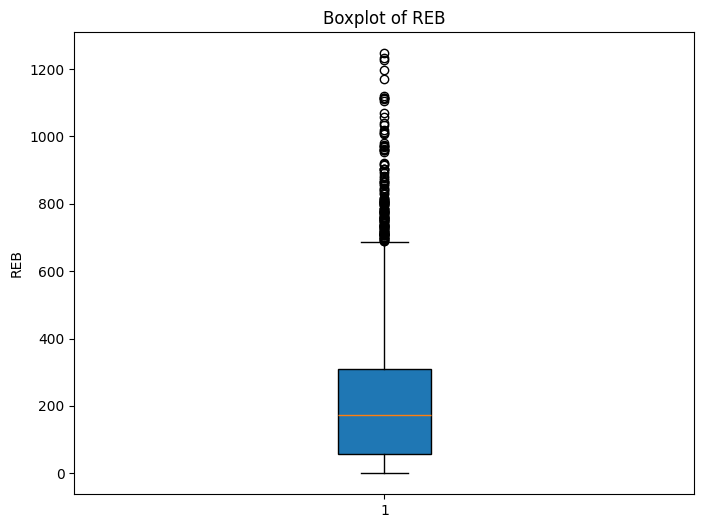


Summary statistics for REB:
count    4037.000000
mean      215.780282
std       197.606003
min         0.000000
25%        58.000000
50%       173.000000
75%       310.000000
max      1247.000000
Name: REB, dtype: float64
------------------------------------------------------------


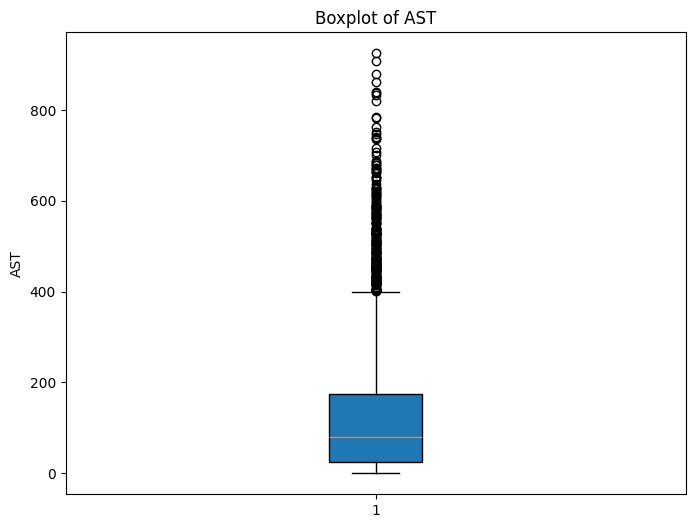


Summary statistics for AST:
count    4037.000000
mean      126.402527
std       140.554367
min         0.000000
25%        25.000000
50%        79.000000
75%       175.000000
max       925.000000
Name: AST, dtype: float64
------------------------------------------------------------


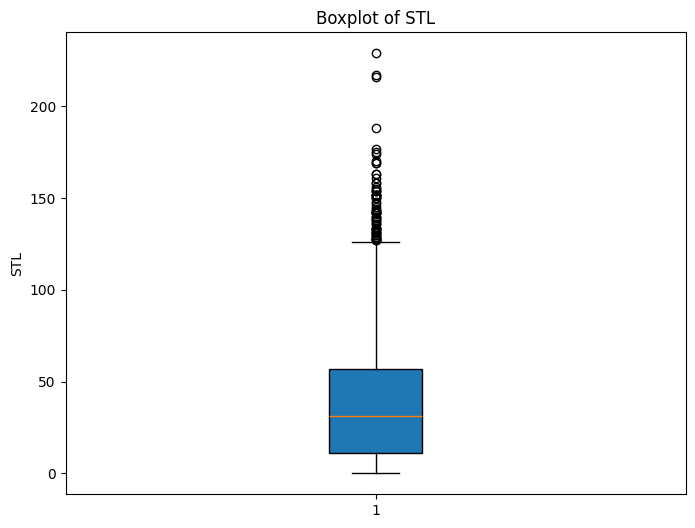


Summary statistics for STL:
count    4037.000000
mean       37.921476
std        32.744499
min         0.000000
25%        11.000000
50%        31.000000
75%        57.000000
max       229.000000
Name: STL, dtype: float64
------------------------------------------------------------


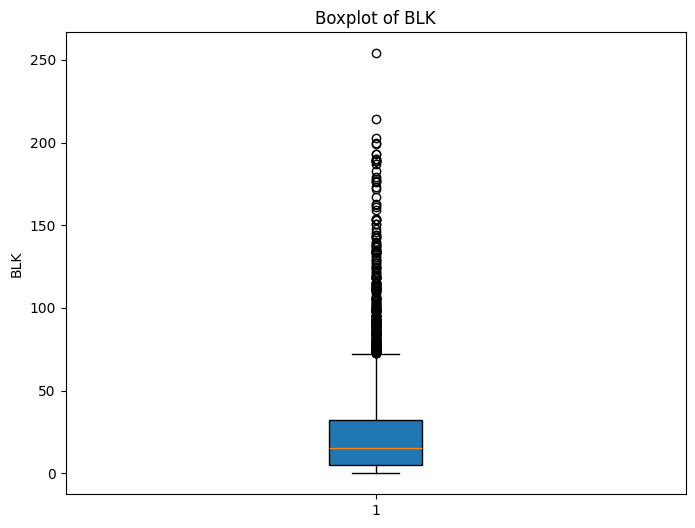


Summary statistics for BLK:
count    4037.000000
mean       24.263314
std        29.335501
min         0.000000
25%         5.000000
50%        15.000000
75%        32.000000
max       254.000000
Name: BLK, dtype: float64
------------------------------------------------------------


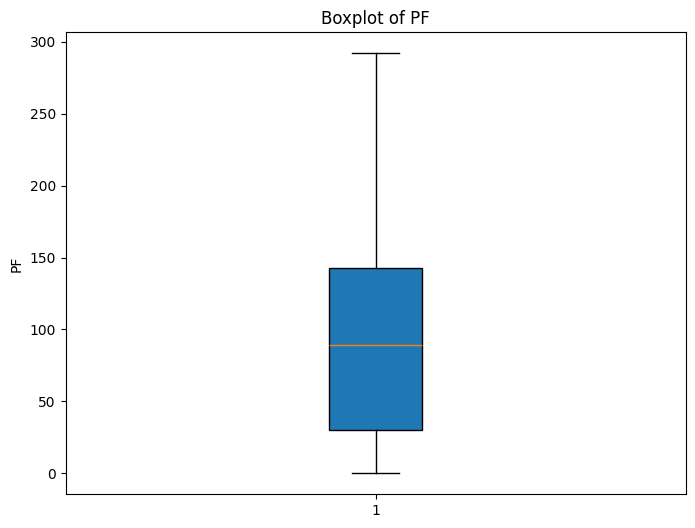


Summary statistics for PF:
count    4037.000000
mean       92.418875
std        66.581743
min         0.000000
25%        30.000000
50%        89.000000
75%       143.000000
max       292.000000
Name: PF, dtype: float64
------------------------------------------------------------


In [36]:
# list of variables
vars = [
    "PLAYER_AGE", "GP", "MIN", "FG_PCT", "FG3A", "FG3_PCT", "FT_PCT", "REB", "AST", "STL", "BLK", "PF"
]

# loop through variables and create a boxplot
for col in vars:
    plt.figure(figsize=(8, 6))
    plt.boxplot(x=data[col], patch_artist=True)
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.show()
    
    # display summary
    print(f"\nSummary statistics for {col}:")
    print(data[col].describe())
    print("-" * 60)

# Step 4 - Data Exploration

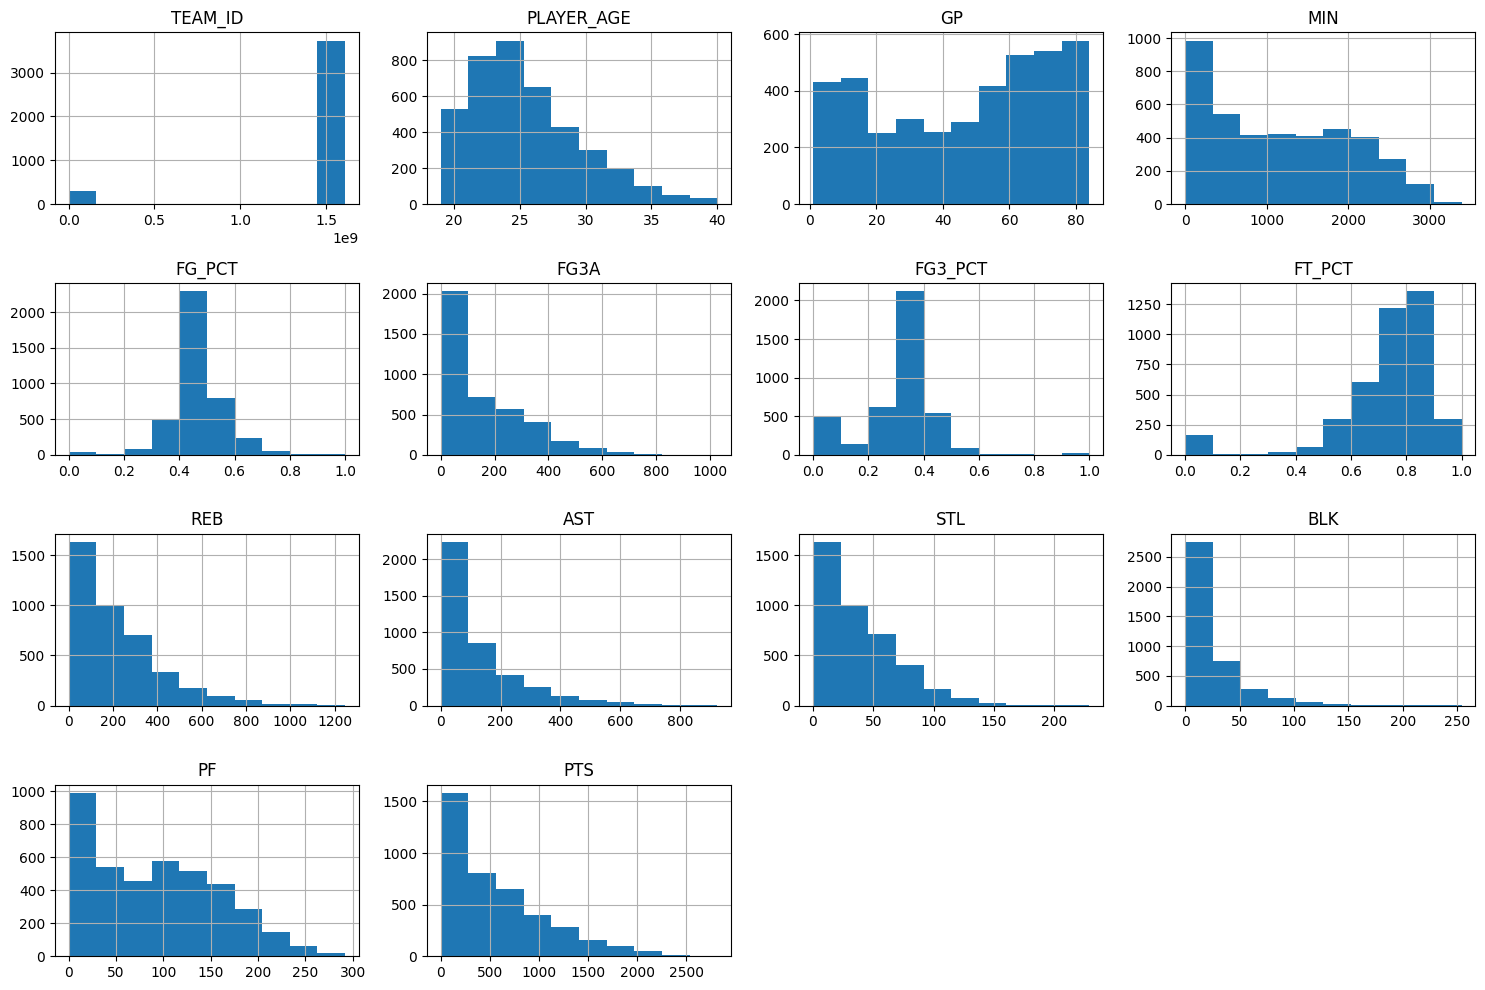

PLAYER_AGE
24.0    481
25.0    430
23.0    428
22.0    398
26.0    354
27.0    298
21.0    294
28.0    225
29.0    207
20.0    201
30.0    165
31.0    137
32.0    113
33.0     89
34.0     57
35.0     45
19.0     35
36.0     29
37.0     19
39.0     14
38.0     13
40.0      5
Name: count, dtype: int64


In [37]:
# Step 1 - Univariate Analysis
data.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

# For categorical variables
print(data['PLAYER_AGE'].value_counts())

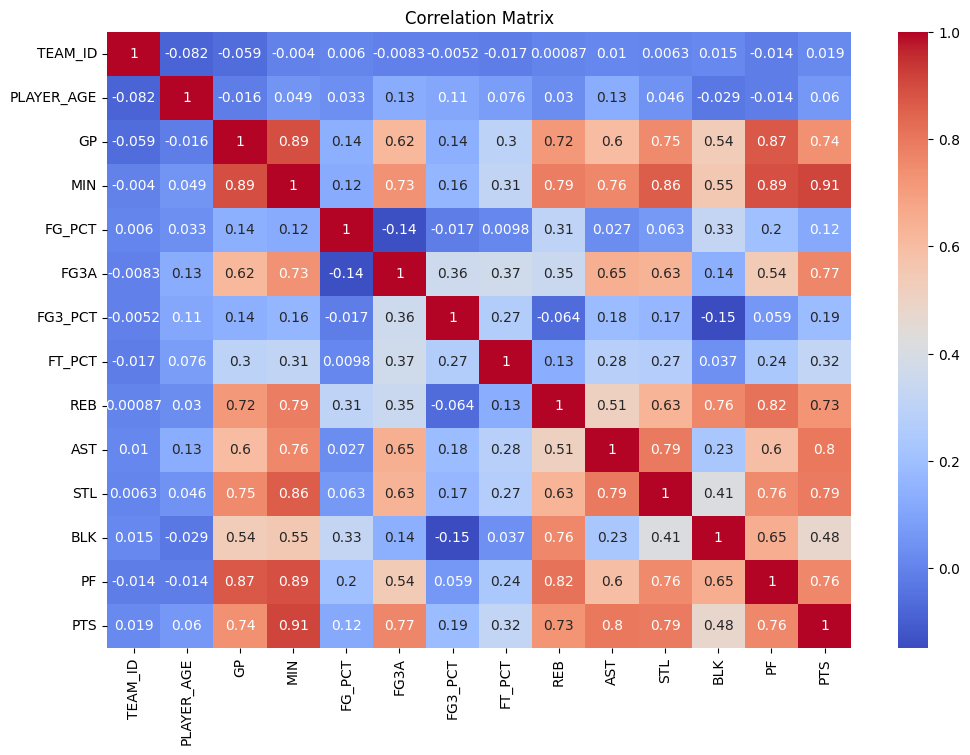

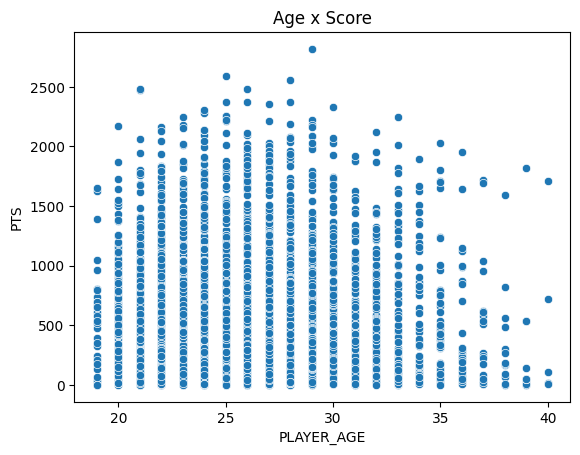

In [38]:
# Bivariate Analysis 
import seaborn as sns

# Correlation between numeric variables
corr = data.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Relation between age and score
sns.scatterplot(x='PLAYER_AGE', y='PTS', data=data)
plt.title('Age x Score')
plt.show()

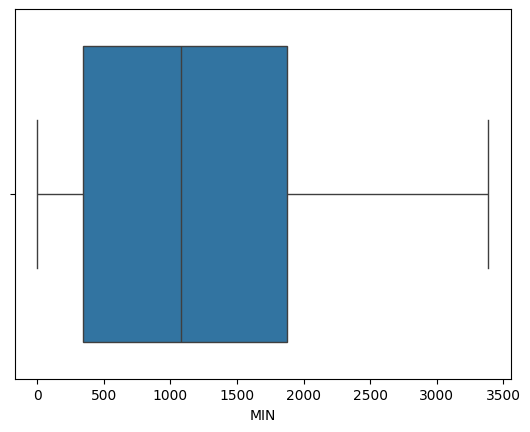

In [12]:
# Outliers Detection
sns.boxplot(x=data['MIN'])
plt.show()

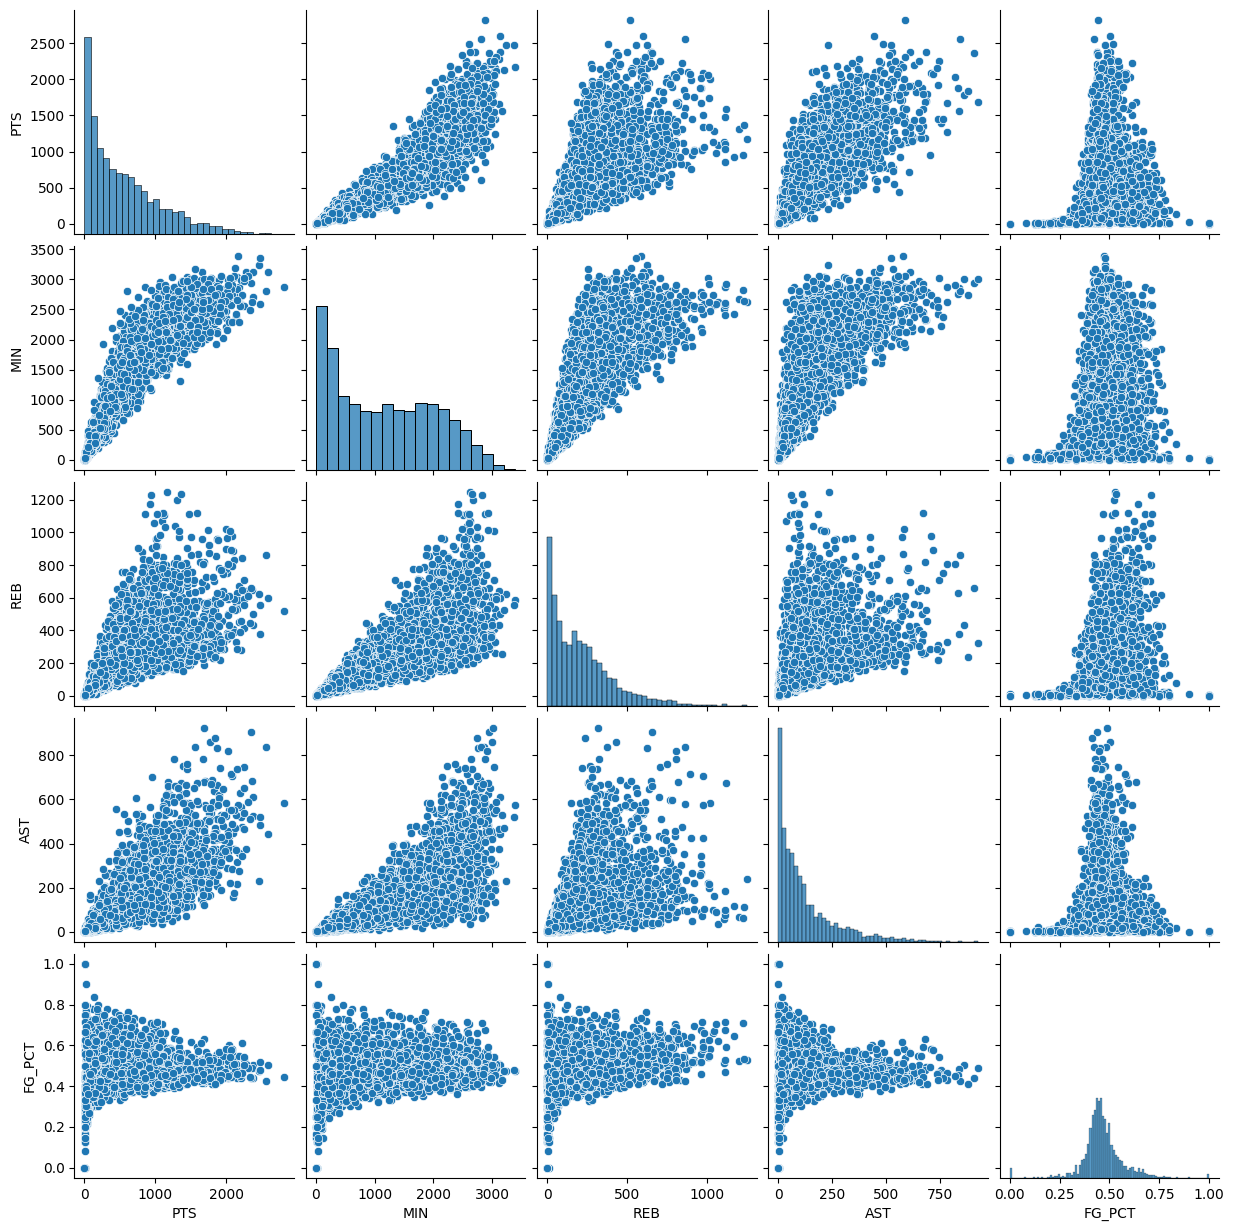

In [39]:
# Correlation
# Analyze how variables like minutes played, rebounds, assists etc. influence points.
sns.pairplot(data[['PTS', 'MIN', 'REB', 'AST', 'FG_PCT']])
plt.show()

# Step 5 - Feature Engineering

## Correlation

# Step 6 - Predictive Modelling

# Step 7 - Findings